<a href="https://colab.research.google.com/github/ArshadJafri/LLM_Centaur/blob/main/Model_Build2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json, re, torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import TrainingArguments, Trainer, default_data_collator, EarlyStoppingCallback



In [2]:
model_name = "marcelbinz/Llama-3.1-Minitaur-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

EOS = tokenizer.eos_token or ""
MAX_LEN = 256

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

In [3]:
def convert_to_psych101(old_ds):
    new_rows = {"text": [], "experiment": [], "participant": []}

    for row in old_ds:
        participant = row["participant"]

        answers = re.findall(r"<<(.*?)>>", row["text"])
        chunks = re.split(r"<<.*?>>", row["text"])

        for chunk, ans in zip(chunks, answers):
            chunk = chunk.strip()
            if "The case reads:" in chunk:
                case = chunk.split("The case reads:")[-1].strip()
                text_input = f"The case reads: {case} How severe is the PTSD? You answer <<"
                label = ans.strip() + ">>"

                new_rows["text"].append(text_input)
                new_rows["experiment"].append(label)
                new_rows["participant"].append(participant)

    return Dataset.from_dict(new_rows)

In [6]:
import json

input_file = "/content/sample_data/final_row_prompt.json"     # your JSON file
output_file = "/content/sample_data/final_row_prompt.jsonl"   # new JSONL file

# Load the full JSON (list of dicts)
with open(input_file, "r") as f:
    data = json.load(f)

# Save each entry on a new line (JSONL format)
with open(output_file, "w") as f:
    for row in data:
        f.write(json.dumps(row) + "\n")

print(f"✅ Converted {len(data)} rows to {output_file}")


✅ Converted 27500 rows to /content/sample_data/final_row_prompt.jsonl


In [7]:
from datasets import load_dataset

# Load JSONL dataset into Hugging Face format
raw_ds = load_dataset("json", data_files={
    "train": "/content/sample_data/final_row_prompt.jsonl",
    "validation": "/content/sample_data/final_row_prompt.jsonl"  # <-- you may want a different file
})

print(raw_ds)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 27500
    })
    validation: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 27500
    })
})


In [4]:
new_train = convert_to_psych101(raw_ds["train"])
new_val   = convert_to_psych101(raw_ds["validation"])

psych101_like_ds = DatasetDict({
    "train": new_train,
    "validation": new_val
})

print(psych101_like_ds)

NameError: name 'raw_ds' is not defined

In [ ]:
def build_example(prompt: str, completion: str):
    prompt_text = prompt.strip()
    completion_text = " " + str(completion).strip() + EOS

    p = tokenizer(prompt_text, add_special_tokens=False).input_ids
    c = tokenizer(completion_text, add_special_tokens=False).input_ids

    input_ids = p + c
    labels = [-100] * len(p) + c
    attn = [1] * len(input_ids)

    if len(input_ids) > MAX_LEN:
        input_ids = input_ids[-MAX_LEN:]
        labels    = labels[-MAX_LEN:]
        attn      = attn[-MAX_LEN:]

    pad = MAX_LEN - len(input_ids)
    if pad > 0:
        input_ids += [tokenizer.pad_token_id] * pad
        labels    += [-100] * pad
        attn      += [0] * pad

    return {"input_ids": input_ids, "attention_mask": attn, "labels": labels}


In [ ]:
def preprocess(batch):
    out = {"input_ids": [], "attention_mask": [], "labels": []}
    for txt, exp in zip(batch["text"], batch["experiment"]):
        ex = build_example(txt, exp)
        for k in out:
            out[k].append(ex[k])
    return out

tokenized_ds = psych101_like_ds.map(
    preprocess,
    batched=True,
    remove_columns=psych101_like_ds["train"].column_names
).with_format("torch")

print(tokenized_ds)

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

device_map = {"": 0}

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    trust_remote_code=True,
)

model.config.use_cache = False

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

if getattr(model, "gradient_checkpointing", False):
    try:
        model.gradient_checkpointing_disable()
    except Exception:
        pass
model.config.use_cache = True

In [ ]:
has_cuda = torch.cuda.is_available()
cap = torch.cuda.get_device_capability(0) if has_cuda else (0, 0)
is_ampere_plus = has_cuda and cap[0] >= 8

use_bf16 = is_ampere_plus
use_fp16 = has_cuda and not use_bf16

print(f"CUDA: {has_cuda}, capability: {cap}, bf16: {use_bf16}, fp16: {use_fp16}")


In [ ]:
MAX_STEPS = 200
EVAL_STEPS = 50
SAVE_STEPS = 50

args = TrainingArguments(
    output_dir="/content/sample_data/minitaur-ptsd",
    max_steps=MAX_STEPS,

    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    gradient_accumulation_steps=1,

    learning_rate=2e-4,
    logging_steps=10,
    evaluation_strategy="steps",   # use built-in eval strategy
    eval_steps=EVAL_STEPS,
    save_steps=SAVE_STEPS,
    save_total_limit=2,

    fp16=use_fp16,
    bf16=use_bf16,
    remove_unused_columns=False,
    report_to="wandb",
)


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=default_data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()

In [1]:
import json

input_file = "/content/sample_data/final_row_prompt.json"     # your JSON file (list of dicts)
output_file = "/content/sample_data/final_row_prompt.jsonl"   # output JSONL

with open(input_file, "r") as f:
    data = json.load(f)

with open(output_file, "w") as f:
    for row in data:
        f.write(json.dumps(row) + "\n")

print(f"✅ Converted {len(data)} rows to {output_file}")



✅ Converted 27500 rows to /content/sample_data/final_row_prompt.jsonl


In [2]:
from datasets import load_dataset, DatasetDict

# Load JSONL into HF dataset
raw = load_dataset("json", data_files=output_file)["train"]

# Split 90% train / 10% validation
raw_ds = raw.train_test_split(test_size=0.1, seed=42)
raw_ds = DatasetDict({
    "train": raw_ds["train"],
    "validation": raw_ds["test"]
})

print(raw_ds)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 24750
    })
    validation: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 2750
    })
})


In [3]:
from datasets import Dataset, DatasetDict

def convert_structured_psych101(old_ds):
    new_rows = {"text": [], "experiment": [], "participant": []}

    for row in old_ds:
        case = row["event_description"]
        rating = row["event_rating"]
        level = row["PTSD_Level"]
        participant = str(row["participantid_num"])

        text_input = f"The case reads: {case}. How severe is the PTSD? You answer <<"
        label = f"{float(rating):.1f} with {level}>>"

        new_rows["text"].append(text_input)
        new_rows["experiment"].append(label)
        new_rows["participant"].append(participant)

    return Dataset.from_dict(new_rows)

# Apply to your DatasetDict
new_train = convert_structured_psych101(raw_ds["train"])
new_val   = convert_structured_psych101(raw_ds["validation"])

psych101_like_ds = DatasetDict({
    "train": new_train,
    "validation": new_val
})

print(psych101_like_ds)
print(psych101_like_ds["train"][0])


DatasetDict({
    train: Dataset({
        features: ['text', 'experiment', 'participant'],
        num_rows: 24750
    })
    validation: Dataset({
        features: ['text', 'experiment', 'participant'],
        num_rows: 2750
    })
})
{'text': 'The case reads: was knocked unconscious in a bicycle accident. How severe is the PTSD? You answer <<', 'experiment': '7.0 with High PTSD>>', 'participant': '139'}


In [4]:
print(raw_ds["train"].column_names)
print(raw_ds["train"][0])

['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num']
{'Age': 25, 'Gender': 'Male', 'PTSD_Level': 'High PTSD', 'PreviousDiagnosis_List': None, 'PreviousDiagnosis_Other': None, 'event_description': 'was knocked unconscious in a bicycle accident', 'event_rating': 7.0, 'participantid_num': 139}


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "marcelbinz/Llama-3.1-Minitaur-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

EOS = tokenizer.eos_token or ""
MAX_LEN = 256

def build_example(prompt: str, completion: str):
    prompt_text = prompt.strip()
    completion_text = " " + str(completion).strip() + EOS

    p = tokenizer(prompt_text, add_special_tokens=False).input_ids
    c = tokenizer(completion_text, add_special_tokens=False).input_ids

    input_ids = p + c
    labels = [-100] * len(p) + c
    attn = [1] * len(input_ids)

    if len(input_ids) > MAX_LEN:
        input_ids = input_ids[-MAX_LEN:]
        labels    = labels[-MAX_LEN:]
        attn      = attn[-MAX_LEN:]

    pad = MAX_LEN - len(input_ids)
    if pad > 0:
        input_ids += [tokenizer.pad_token_id] * pad
        labels    += [-100] * pad
        attn      += [0] * pad

    return {"input_ids": input_ids, "attention_mask": attn, "labels": labels}

def preprocess(batch):
    out = {"input_ids": [], "attention_mask": [], "labels": []}
    for txt, exp in zip(batch["text"], batch["experiment"]):
        ex = build_example(txt, exp)
        for k in out:
            out[k].append(ex[k])
    return out

tokenized_ds = psych101_like_ds.map(
    preprocess,
    batched=True,
    remove_columns=psych101_like_ds["train"].column_names
).with_format("torch")

print(tokenized_ds)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/24750 [00:00<?, ? examples/s]

Map:   0%|          | 0/2750 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 24750
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2750
    })
})


In [8]:
!pip install bitsandbytes accelerate transformers peft datasets

In [9]:
!pip install -U bitsandbytes
!pip install -U accelerate transformers peft datasets

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print("Torch:", torch.__version__)

# Confirm bitsandbytes is available
import bitsandbytes as bnb
print("Bitsandbytes version:", bnb.__version__)

Torch: 2.8.0+cu126
Bitsandbytes version: 0.47.0


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "marcelbinz/Llama-3.1-Minitaur-8B"

# Quantization config (4-bit)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

# Load model in 4-bit
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",          # let accelerate map layers to GPU
    trust_remote_code=True,
)

print("✅ Model loaded in 4-bit quantization on GPU")


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

✅ Model loaded in 4-bit quantization on GPU


In [8]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


In [9]:
has_cuda = torch.cuda.is_available()
cap = torch.cuda.get_device_capability(0) if has_cuda else (0, 0)
is_ampere_plus = has_cuda and cap[0] >= 8

use_bf16 = is_ampere_plus
use_fp16 = has_cuda and not use_bf16

print(f"CUDA: {has_cuda}, capability: {cap}, bf16: {use_bf16}, fp16: {use_fp16}")


CUDA: True, capability: (8, 0), bf16: True, fp16: False


In [16]:
from transformers import TrainingArguments, Trainer, default_data_collator, EarlyStoppingCallback

print("Transformers version:", transformers.__version__)

EVAL_STEPS = 500
SAVE_STEPS = 500
EPOCHS     = 3
TRAIN_BS   = 16
EVAL_BS    = 16

args = TrainingArguments(
    output_dir="/content/sample_data/minitaur-ptsd",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    gradient_accumulation_steps=1,
    learning_rate=2e-4,
    logging_steps=100,

    # ✅ use eval_strategy not evaluation_strategy
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_steps=SAVE_STEPS,
    save_total_limit=2,

    remove_unused_columns=False,
    load_best_model_at_end=True,          # now valid
    metric_for_best_model="eval_loss",    # track eval loss
    greater_is_better=False,              # smaller loss is better

    fp16=use_fp16,
    bf16=use_bf16,
    report_to="wandb",
)

callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=default_data_collator,
    callbacks=callbacks,
)

trainer.train()


Transformers version: 4.56.1


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
500,0.156900,0.157143
1000,0.153500,0.152554
1500,0.148900,0.151855
2000,0.148400,0.152406
2500,0.148000,0.150501
3000,0.143900,0.150909
3500,0.144300,0.150025
4000,0.144400,0.149477


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/

Step,Training Loss,Validation Loss
500,0.156900,0.157143
1000,0.153500,0.152554
1500,0.148900,0.151855
2000,0.148400,0.152406
2500,0.148000,0.150501
3000,0.143900,0.150909
3500,0.144300,0.150025
4000,0.144400,0.149477
4500,0.142300,0.149428


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=4641, training_loss=0.1511664678248525, metrics={'train_runtime': 10365.9342, 'train_samples_per_second': 7.163, 'train_steps_per_second': 0.448, 'total_flos': 8.60705168818176e+17, 'train_loss': 0.1511664678248525, 'epoch': 3.0})

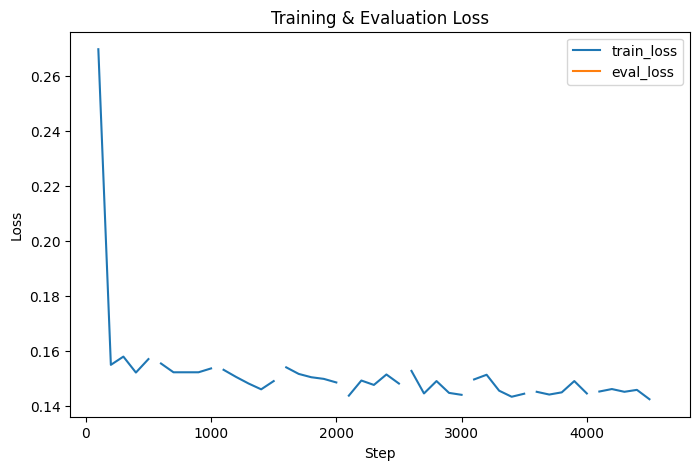

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert logs to DataFrame
history = pd.DataFrame(trainer.state.log_history)

# Plot loss
plt.figure(figsize=(8,5))
plt.plot(history["step"], history["loss"], label="train_loss")
if "eval_loss" in history:
    plt.plot(history["step"], history["eval_loss"], label="eval_loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Evaluation Loss")
plt.show()


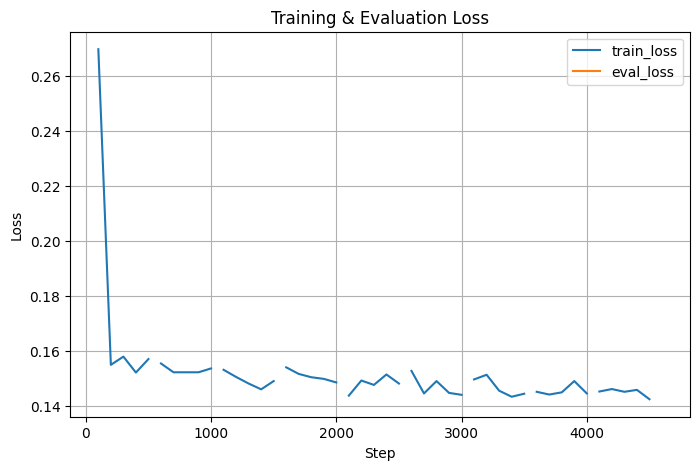

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert logs to DataFrame
history = pd.DataFrame(trainer.state.log_history)

# Plot train & eval loss
plt.figure(figsize=(8,5))

if "loss" in history:
    plt.plot(history["step"], history["loss"], label="train_loss")

if "eval_loss" in history:
    plt.plot(history["step"], history["eval_loss"], label="eval_loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import math

def compute_metrics(eval_pred):
    # Hugging Face Trainer passes an EvalPrediction object
    # It has .metrics containing "eval_loss"
    metrics = {}
    if "eval_loss" in eval_pred.metrics:
        loss = eval_pred.metrics["eval_loss"]
        try:
            metrics["perplexity"] = math.exp(loss)
        except OverflowError:
            metrics["perplexity"] = float("inf")
    return metrics


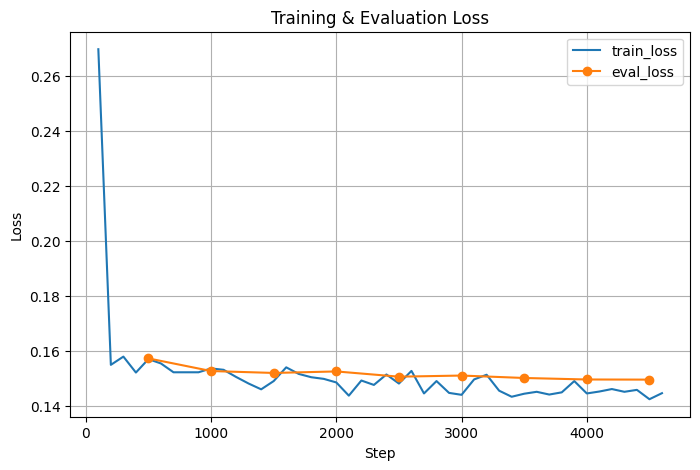

In [21]:
import matplotlib.pyplot as plt

# Extract step/loss values properly
train_steps, train_losses = [], []
eval_steps, eval_losses   = [], []

for log in trainer.state.log_history:
    if "loss" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_losses.append(log["eval_loss"])

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_steps, train_losses, label="train_loss")
plt.plot(eval_steps, eval_losses, label="eval_loss", marker="o")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
model.eval()

test_prompts = [
    "The case reads: failed an exam. How severe is the PTSD? You answer <<",
    "The case reads: witnessed a child being shot. How severe is the PTSD? You answer <<",
    "The case reads: went for a walk in the park. How severe is the PTSD? You answer <<"
]

for prompt in test_prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=20,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"\nPrompt: {prompt}")
    print(f"Model completion: {output_text[len(prompt):].strip()}")



Prompt: The case reads: failed an exam. How severe is the PTSD? You answer <<
Model completion: 4.0 with Medium PTSD>>

Prompt: The case reads: witnessed a child being shot. How severe is the PTSD? You answer <<
Model completion: 7.0 with High PTSD>>

Prompt: The case reads: went for a walk in the park. How severe is the PTSD? You answer <<
Model completion: 1.0 with Low PTSD>>
